In [76]:
import pandas as pd
import numpy as np
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import callbacks
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from keras.layers import Dense, Dropout
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report,f1_score, precision_score, recall_score, accuracy_score
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

warnings.filterwarnings(action='ignore')
tf.config.set_visible_devices([], 'GPU')

In [77]:
df = pd.read_csv("data/modified_0420.csv")
reversed_df = df.drop(columns=['Unnamed: 0']).copy()
# reversed_df['loan_status'] = reversed_df['loan_status'].map({1:0, 0:1})
reversed_df['loan_status']

0          0
1          1
2          1
3          0
4          0
          ..
1131677    0
1131678    1
1131679    0
1131680    0
1131681    0
Name: loan_status, Length: 1131682, dtype: int64

In [29]:
reversed_df.shape
reversed_df.to_csv('data/modified_0420_reversed.csv')

In [27]:
df.shape

(1131682, 91)

In [78]:
df = pd.read_csv("data/modified_0420.csv")
x_train = df.drop(columns=['loan_status', 'Unnamed: 0'])
y_train = df['loan_status']

In [79]:
nan_indices = np.isnan(x_train).any(axis=1)
x_train = x_train[~nan_indices]
y_train = y_train[~nan_indices]

In [66]:
y_train_reshaped

array([1, 0, 0, ..., 1, 1, 0], dtype=int64)

In [80]:
# minmax scaler 찾아보기
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x_train)

[0.15351255 0.23887498 0.29132949 0.33460378 0.37342152 0.40992361
 0.44018213 0.46830687 0.49304401 0.51586528 0.53721772 0.55750293
 0.57607956 0.59350761 0.60844465 0.62254463 0.63602833 0.64925373
 0.66216411 0.67429034 0.68602493 0.69753601 0.70896553 0.7203637
 0.73171759 0.74305794 0.75434201 0.76561303 0.77685392 0.78806636
 0.79920845 0.81031344 0.8213071  0.83225873 0.843079   0.85338506
 0.86359883 0.87338488 0.88257324 0.89131271 0.89893998 0.90642617
 0.91346178 0.9200401  0.92612666 0.93178941 0.93700023 0.94206948
 0.9466856  0.95121647 0.95564362 0.95970912 0.96346197 0.96705088
 0.97012257 0.9729337  0.97537772 0.97757369 0.97956607 0.98142723
 0.9830844  0.98459436 0.98608351 0.98749547 0.98884414 0.99014148
 0.99140624 0.99253264 0.99357978 0.99458026 0.99551418 0.99635191
 0.99705684 0.99757707 0.99805306 0.99842364 0.99877569 0.99905902
 0.99931589 0.99949095 0.99965833 0.99977262 0.99987296 0.99993982
 0.99999192 1.         1.         1.         1.        ]


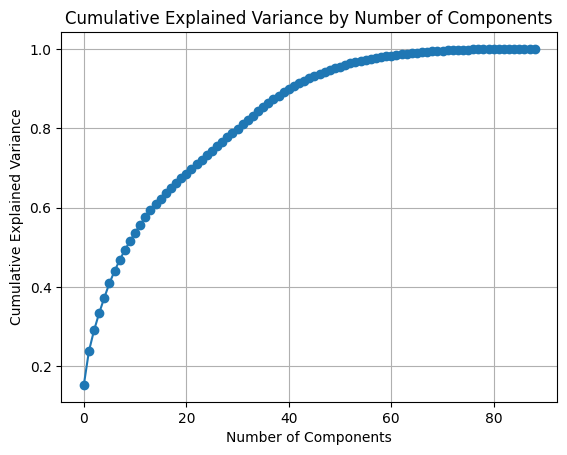

50

In [33]:
def get_n_components_from_pca(scaled_data:pd.DataFrame, threshold:float) -> int:
    pca = PCA()
    pca.fit(scaled_data)
    explained_variance = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance)
    print(cumulative_explained_variance)
    # 누적 설명 분산 시각화
    plt.plot(cumulative_explained_variance, marker='o', linestyle='-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance by Number of Components')
    plt.grid(True)
    plt.show()
    # 적절한 주성분 개수 선택
    n_components = np.argmax(cumulative_explained_variance >= threshold) + 1
    return n_components
get_n_components_from_pca(X_scaled, 0.95)

In [6]:
n_components

1

In [81]:
# PCA로 차원 축소
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)
x_train = X_pca.astype('float32')
# stratify로 학습에 용이하게 비율 유지
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train)

In [35]:
def f1_score(y_true, y_pred):
    y_true = tf.cast(tf.argmax(y_true, axis = 1), tf.float32)
    y_pred = tf.cast(tf.argmax(y_pred, axis = 1), tf.float32)
    true_positives = K.sum((y_true * y_pred))
    possible_positives = K.sum(y_true)
    predicted_positives = K.sum(y_pred)
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

def recall(y_true, y_pred):
    y_true = tf.cast(tf.argmax(y_true, axis = 1), tf.float32)
    y_pred = tf.cast(tf.argmax(y_pred, axis = 1), tf.float32)
    true_positives = K.sum((y_true * y_pred))
    possible_positives = K.sum(y_true)
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = tf.cast(tf.argmax(y_true, axis = 1), tf.float32)
    y_pred = tf.cast(tf.argmax(y_pred, axis = 1), tf.float32)
    true_positives = K.sum((y_true * y_pred))
    predicted_positives = K.sum(y_pred)
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [7]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())    
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

바로 아래 칸은 최적의 hyperparameter를 찾기 위해서 실행하는 칸이므로, 실행할 필요 없습니다.

모델만을 알고싶다면 넘어가세요.

In [36]:
# GPU 설정
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# KerasClassifier을 위한 build_fn 정의 (build_model)
# 신경망 model 생성
def build_model(num_layers, num_nodes, loss):
    # Define and compile the model
    model = keras.Sequential()
    model.add(Dense(num_nodes, input_dim=50, activation='relu'))
    for _ in range(num_layers):
        model.add(Dense(num_nodes, activation='relu'))
        model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='Adam', loss=loss, metrics=["accuracy"])
    return model
# KFold validation 사용
# k: n_splits=5
kfold = KFold(random_state=30,
           n_splits=5,
           shuffle=True
          )
model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=build_model)

# 최적 hyperparameter을 찾기위한 gridsearchCV를 위한 parameter
parameters = {
    'batch_size': [1000,5000,10000],
    'epochs': [45,60,100],
    'num_layers': [2, 3],
    'num_nodes': [10, 25, 40],
    'loss':["binary_crossentropy"]
    }
# GridSearchCV 생성
grid_search = GridSearchCV(estimator = model,
                           param_grid = parameters,
                           cv = kfold)
early_stopping = EarlyStopping(monitor='loss',min_delta=0.001)
# GridSearchCV fit 시작
grid_search.fit(x_train, y_train, callbacks=[early_stopping])
# 최적의 param
print(f"Best params: {grid_search.best_params_}")
# 최적의 param일 경우 최적의 accuracy
print(f"Best average accuracy: {grid_search.best_score_}")

Epoch 1/45
725/725 [==============================] - 2s 2ms/step - loss: 0.5039 - accuracy: 0.7855
Epoch 2/45
182/182 [==============================] - 0s 903us/step - loss: 0.4575 - accuracy: 0.7997
Epoch 1/45
725/725 [==============================] - 2s 2ms/step - loss: 0.5089 - accuracy: 0.7832
Epoch 2/45
182/182 [==============================] - 0s 824us/step - loss: 0.4570 - accuracy: 0.7992
Epoch 1/45
725/725 [==============================] - 2s 2ms/step - loss: 0.5249 - accuracy: 0.7665
Epoch 2/45
182/182 [==============================] - 0s 853us/step - loss: 0.4598 - accuracy: 0.7969
Epoch 1/45
725/725 [==============================] - 2s 2ms/step - loss: 0.5042 - accuracy: 0.7849
Epoch 2/45
182/182 [==============================] - 0s 890us/step - loss: 0.4586 - accuracy: 0.7986
Epoch 1/45
725/725 [==============================] - 2s 2ms/step - loss: 0.5148 - accuracy: 0.7780
Epoch 2/45
182/182 [==============================] - 0s 850us/step - loss: 0.4584 - accurac

In [35]:
# grid_search를 수행했을 경우의 각각의 결과s
# Best params(PCA1_feature86): {'batch_size': 1000, 'epochs': 60, 'loss': 'binary_crossentropy', 'num_layers':s 2, 'num_nodes': 40
# Best params(PCA95_feature50): {'batch_size': 1000, 'epochs': 100, 'loss': 'binary_crossentropy', 'num_layers': 2, 'num_nodes': 40}
# Best params(PCA95_feature50,reversed): {'batch_size': 1000, 'epochs': 60, 'loss': 'binary_crossentropy', 'num_layers': 2, 'num_nodes': 40}

result = grid_search.cv_results_

아래는 위의 모델을 생성한 결과를 바탕으로 hyperparameter를 설정한 모델입니다.

## 최적 모델(without EarlyStopping)
- avg accuracy: 0.8004517912864685
- avg F1-score: 0.8004525303840637
- avg recall: 0.8004526019096374
- avg precision: 0.8004526019096374

In [13]:
# GPU 설정
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)
   print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [82]:
y_train_reshaped = np.reshape(y_train,(-1))
y_train_reshaped.shape


(905345,)

In [83]:
y_train_reshaped.shape

(905345,)

In [84]:
# # 최고의 파라미터 : {'batch_size': 1000, 'epochs': 100, 'loss': 'categorical_crossentropy', 'num_layers': 2, 'num_nodes': 40}
valid_accs, valid_f1s, valid_recalls, valid_precisions = [], [], [], []
best_params = grid_search.best_params_
print(best_params)
# 신경망층 설계
model = keras.Sequential()
model.add(Dense(40, input_dim=50, activation='relu'))
for _ in range(2):
    model.add(Dense(40, activation='relu'))
    model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
# 모델 컴파일
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=["accuracy"])
# KFoldvalidation 사용함(k=5)
kf = KFold(n_splits=5, shuffle=True, random_state=30)
early_stopping = EarlyStopping(monitor='loss',min_delta=0.001)
for train_index, val_index in kf.split(x_train, y_train_reshaped):
    X_train_fold, X_val_fold = x_train[train_index], x_train[val_index]
    Y_train_fold, Y_val_fold = y_train_reshaped[train_index], y_train_reshaped[val_index]
    # 모델 학습
    model.fit(X_train_fold, 
              Y_train_fold, 
              batch_size=1000, 
              epochs=60, 
              verbose=1,
              callbacks=[early_stopping])
    # 모델 validation
    valid_loss, valid_acc= model.evaluate(X_val_fold, Y_val_fold)
    valid_accs.append(valid_acc)
    print("===================================")
    print("Validation accuracy:", valid_acc)

    pred = model.predict(X_val_fold)
    preds_1d = pred.flatten()
    pred = np.where(preds_1d > 0.5, 1 , 0)
    valid_f1s.append(f1_score(Y_val_fold, pred))
    valid_precisions.append(precision_score(Y_val_fold, pred))
    valid_recalls.append(recall_score(Y_val_fold, pred))
print("###################################")
print("avg Validation accuracy:", np.mean(valid_accs))
print("avg Validation F1-score:", np.mean(valid_f1s))
print("avg Validation recall:", np.mean(valid_recalls))
print("avg Validation precision:", np.mean(valid_precisions))


{'batch_size': 1000, 'epochs': 60, 'loss': 'binary_crossentropy', 'num_layers': 2, 'num_nodes': 40}
Epoch 1/60
725/725 [==============================] - 4s 4ms/step - loss: 0.4718 - accuracy: 0.7984
Epoch 2/60
5659/5659 [==============================] - 4s 721us/step - loss: 0.4583 - accuracy: 0.7994
Validation accuracy: 0.799407958984375
5659/5659 [==============================] - 4s 670us/step
Epoch 1/60
725/725 [==============================] - 3s 4ms/step - loss: 0.4576 - accuracy: 0.8004
Epoch 2/60
5659/5659 [==============================] - 4s 770us/step - loss: 0.4538 - accuracy: 0.8014
Validation accuracy: 0.8014127016067505
5659/5659 [==============================] - 4s 680us/step
Epoch 1/60
725/725 [==============================] - 3s 4ms/step - loss: 0.4558 - accuracy: 0.8010
Epoch 2/60
5659/5659 [==============================] - 4s 745us/step - loss: 0.4532 - accuracy: 0.8014
Validation accuracy: 0.8014237880706787
5659/5659 [==============================] - 4s 667

In [85]:
valid_pred = model.predict(x_validation)
valid_preds_1d = valid_pred.flatten()
valid_pred = np.where(valid_preds_1d>0.5, 1, 0)
print("###################################")
print("Validation accuracy:", accuracy_score(y_validation, valid_pred))
print("Validation F1-score:", f1_score(y_validation, valid_pred))
print("Validation recall:", recall_score(y_validation, valid_pred))
print("Validation precision:", precision_score(y_validation, valid_pred))

7074/7074 [==============================] - 5s 677us/step
###################################
Validation accuracy: 0.8009958601554319
Validation F1-score: 0.08614672942704106
Validation recall: 0.04641756127424186
Validation precision: 0.5978597578147001


In [75]:
model.save('dnn_models/log_transformed/pca95_feature50/with_earlystopping001_0422(binary).h5')

In [16]:
import tensorflow as tf
tf.test.is_built_with_cuda()

True

## 최적 model(with EarlyStopping)
### earlystopping: min_delta was 0.001
- avg accuracy: 0.7999342799186706
- avg F1-score: 0.7999348163604736
- avg recall: 0.7999348998069763
- avg precision: 0.7999348998069763

### earlystopping: min_delta was 0.0001
- avg accuracy: 0.80015869140625
- avg F1-score: 0.8001592040061951
- avg recall: 0.8001593112945556
- avg precision: 0.8001593112945556

In [17]:
# # 최고의 파라미터 : {'batch_size': 1000, 'epochs': 100, 'loss': 'categorical_crossentropy', 'num_layers': 2, 'num_nodes': 40}
valid_accs, valid_f1s, valid_recalls, valid_precisions = [], [], [], []
best_params = grid_search.best_params_

# 신경망층 설계
model = keras.Sequential()
model.add(Dense(best_params['num_nodes'], input_dim=86, activation='relu'))
for _ in range(best_params['num_layers']):
    model.add(Dense(best_params['num_nodes'], activation='relu'))
    model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Dense(2, activation='softmax'))
# 모델 컴파일
model.compile(loss=best_params['loss'], optimizer='Adam', metrics=["accuracy", f1_score, recall, precision])
# KFoldvalidation 사용함(k=5)
kf = KFold(n_splits=5, shuffle=True, random_state=30)
early_stopping = EarlyStopping(monitor='loss',min_delta=0.001)
for train_index, val_index in kf.split(x_train, y_train):
    X_train_fold, X_val_fold = x_train[train_index], x_train[val_index]
    Y_train_fold, Y_val_fold = y_train[train_index], y_train[val_index]
    # 모델 학습
    model.fit(X_train_fold, Y_train_fold, 
              batch_size=best_params['batch_size'], 
              epochs=best_params['epochs'], 
              verbose=1,
              callbacks=[early_stopping])

    # 모델 validation
    valid_loss, valid_acc, valid_f1, valid_recall, valid_precision = model.evaluate(X_val_fold, Y_val_fold)
    valid_accs.append(valid_acc)
    valid_f1s.append(valid_f1)
    valid_recalls.append(valid_recall)
    valid_precisions.append(valid_precision)
    print("===================================")
    print("Validation accuracy:", valid_acc)
    print("Validation F1-score:", valid_f1)
    print("Validation recall:", valid_recall)
    print("Validation precision:", valid_precision)
print("###################################")
print("avg Validation accuracy:", np.mean(valid_accs))
print("avg Validation F1-score:", np.mean(valid_f1s))
print("avg Validation recall:", np.mean(valid_recalls))
print("avg Validation precision:", np.mean(valid_precisions))
model.save('dnn_models/non_log_transformed/pca1_feature86/with_earlystopping_001_0421.h5')

Epoch 1/100
725/725 [==============================] - 3s 3ms/step - loss: 0.4687 - accuracy: 0.7984 - f1_score: 0.7984 - recall: 0.7984 - precision: 0.7984
Epoch 2/100
5659/5659 [==============================] - 6s 1ms/step - loss: 0.4541 - accuracy: 0.8005 - f1_score: 0.8006 - recall: 0.8006 - precision: 0.8006
Validation accuracy: 0.8005456328392029
Validation F1-score: 0.8005503416061401
Validation recall: 0.8005504608154297
Validation precision: 0.8005504608154297
Epoch 1/100
725/725 [==============================] - 2s 3ms/step - loss: 0.4555 - accuracy: 0.8004 - f1_score: 0.8004 - recall: 0.8004 - precision: 0.8004
Epoch 2/100
5659/5659 [==============================] - 6s 1ms/step - loss: 0.4532 - accuracy: 0.8019 - f1_score: 0.8019 - recall: 0.8019 - precision: 0.8019
Validation accuracy: 0.8019374012947083
Validation F1-score: 0.801925778388977
Validation recall: 0.8019258975982666
Validation precision: 0.8019258975982666
Epoch 1/100
725/725 [==============================

In [18]:
# # 최고의 파라미터 : {'batch_size': 1000, 'epochs': 100, 'loss': 'categorical_crossentropy', 'num_layers': 2, 'num_nodes': 40}
valid_accs, valid_f1s, valid_recalls, valid_precisions = [], [], [], []
best_params = grid_search.best_params_

# 신경망층 설계
model = keras.Sequential()
model.add(Dense(best_params['num_nodes'], input_dim=86, activation='relu'))
for _ in range(best_params['num_layers']):
    model.add(Dense(best_params['num_nodes'], activation='relu'))
    model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Dense(2, activation='softmax'))
# 모델 컴파일
model.compile(loss=best_params['loss'], optimizer='Adam', metrics=["accuracy", f1_score, recall, precision])
# KFoldvalidation 사용함(k=5)
kf = KFold(n_splits=5, shuffle=True, random_state=30)
early_stopping = EarlyStopping(monitor='loss',min_delta=0.0001)
for train_index, val_index in kf.split(x_train, y_train):
    X_train_fold, X_val_fold = x_train[train_index], x_train[val_index]
    Y_train_fold, Y_val_fold = y_train[train_index], y_train[val_index]
    # 모델 학습
    model.fit(X_train_fold, Y_train_fold, 
              batch_size=best_params['batch_size'], 
              epochs=best_params['epochs'], 
              verbose=1,
              callbacks=[early_stopping])

    # 모델 validation
    valid_loss, valid_acc, valid_f1, valid_recall, valid_precision = model.evaluate(X_val_fold, Y_val_fold)
    valid_accs.append(valid_acc)
    valid_f1s.append(valid_f1)
    valid_recalls.append(valid_recall)
    valid_precisions.append(valid_precision)
    print("===================================")
    print("Validation accuracy:", valid_acc)
    print("Validation F1-score:", valid_f1)
    print("Validation recall:", valid_recall)
    print("Validation precision:", valid_precision)
print("###################################")
print("avg Validation accuracy:", np.mean(valid_accs))
print("avg Validation F1-score:", np.mean(valid_f1s))
print("avg Validation recall:", np.mean(valid_recalls))
print("avg Validation precision:", np.mean(valid_precisions))
model.save('dnn_models/non_log_transformed/pca1_feature86/with_earlystopping_0001_0421.h5')

Epoch 1/100
725/725 [==============================] - 3s 4ms/step - loss: 0.4725 - accuracy: 0.7965 - f1_score: 0.7965 - recall: 0.7965 - precision: 0.7965
Epoch 2/100
5659/5659 [==============================] - 6s 1ms/step - loss: 0.4563 - accuracy: 0.8017 - f1_score: 0.8017 - recall: 0.8017 - precision: 0.8017
Validation accuracy: 0.8016557097434998
Validation F1-score: 0.8016602993011475
Validation recall: 0.801660418510437
Validation precision: 0.801660418510437
Epoch 1/100
725/725 [==============================] - 3s 4ms/step - loss: 0.4560 - accuracy: 0.8004 - f1_score: 0.8004 - recall: 0.8004 - precision: 0.8004
Epoch 2/100
5659/5659 [==============================] - 7s 1ms/step - loss: 0.4535 - accuracy: 0.8020 - f1_score: 0.8020 - recall: 0.8020 - precision: 0.8020
Validation accuracy: 0.8019981384277344
Validation F1-score: 0.801986575126648
Validation recall: 0.8019866347312927
Validation precision: 0.8019866347312927
Epoch 1/100
725/725 [==============================] 